In [ ]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer # model to convert text into code, "sentence classification"
import numpy as np # store converted text into numbers
import pandas as pd # dataset

In [ ]:
df = pd.read_csv('write_file_here.csv') # can be automatized as well

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
## new dataframe to store our data
answer_embeddings = df['answer'].apply(lambda x: model.encode(x, convert_to_tensor=True))
response_embeddings = df['model_response'].apply(lambda x: model.encode(x, convert_to_tensor=True))

embedding_df = pd.DataFrame({
    'answer_embedding': answer_embeddings,
    'model_response_embedding': response_embeddings
})

In [ ]:
## COSINE SIMMULARITY

import torch # pytorch

answers = torch.stack(embedding_df['answer_embedding'].tolist())          # 768
responses = torch.stack(embedding_df['model_response_embedding'].tolist()) # 768

cos_sim = torch.nn.functional.cosine_similarity(answers, responses, dim=1)

embedding_df['cosine_similarity'] = cos_sim.tolist()

print("cosine similarity:", cos_sim.mean().item())

In [ ]:
## BERTScore
!pip install bert_score
from bert_score import score

P, R, F1 = score(df['answer'].tolist(), df['model_response'].tolist(), lang='en')
print(f"BERTScore F1: {F1.mean().item():.4f}")

In [ ]:
### comparison (predefined manually for now, can be automatized)
comparison = pd.DataFrame([
    {
        "model": "falcon",
        "bert_score": 0.8710,
        "cosine_similarity": 0.6338
    },
    {
        "model": "phi",
        "bert_score": 0.8722,
        "cosine_similarity": 0.6522
    },
    {
        "model": "tiny-llama",
        "bert_score": 0.8835,
        "cosine_similarity": 0.7044
    },
    {
        "model": "llama-regular",
        "bert_score": 0.8609,
        "cosine_similarity": 0.6323
    }
])

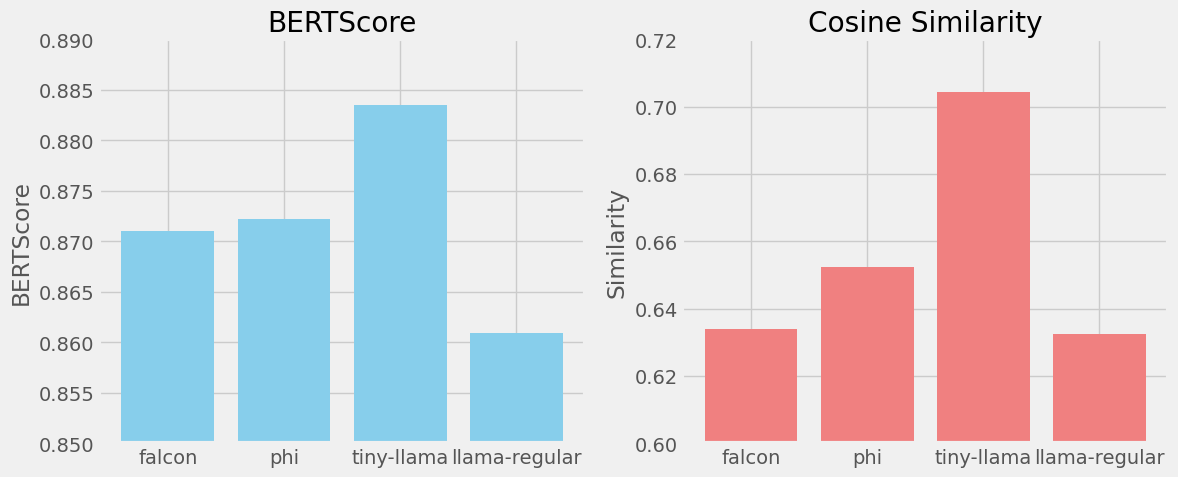

In [22]:
### vizualisation
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# bert
axs[0].bar(comparison['model'], comparison['bert_score'], color='skyblue')
axs[0].set_title('BERTScore')
axs[0].set_ylim(0.85, 0.89)
axs[0].set_ylabel('BERTScore')

# cosines
axs[1].bar(comparison['model'], comparison['cosine_similarity'], color='lightcoral')
axs[1].set_title('Cosine Similarity')
axs[1].set_ylim(0.6, 0.72)
axs[1].set_ylabel('Similarity')

# to show
plt.tight_layout()
plt.show()